In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import io
%matplotlib inline

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving Historical_Data.csv to Historical_Data.csv


In [3]:
df = pd.read_csv(io.BytesIO(data_to_load['Historical_Data.csv']))

In [4]:
df.set_index('Date',drop=True,inplace=True)
df = df.iloc[:,0]
df.dropna(inplace=True)
df

Date
09/09/2023    25871.7
09/08/2023    25872.2
09/07/2023    26269.7
09/06/2023    25826.4
09/05/2023    25785.9
               ...   
03/12/2019     3886.0
03/11/2019     3865.1
03/10/2019     3915.2
03/09/2019     3944.4
03/08/2019     3865.9
Name: Close/Last, Length: 1576, dtype: float64

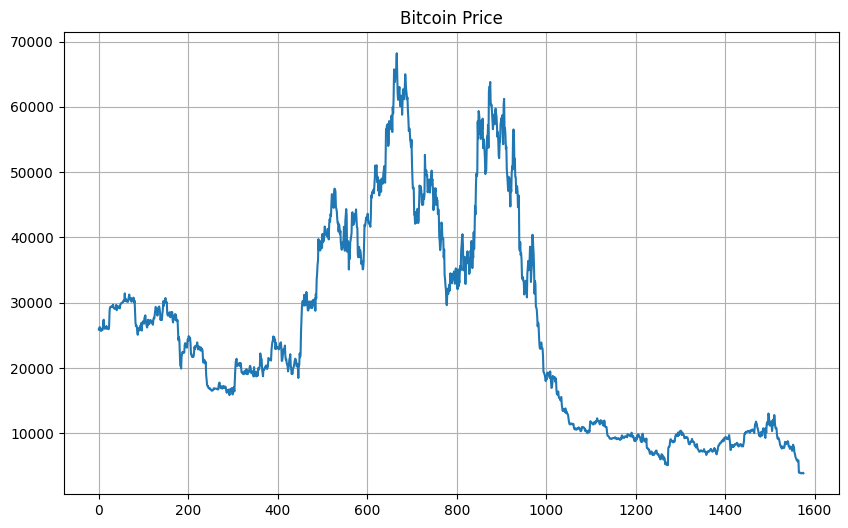

In [5]:
plt.figure(figsize=(10,6))
plt.title("Bitcoin Price")
plt.grid()
plt.plot(np.array(df).reshape(-1,1))

In [6]:
# Sequence the data for the LSTM to learn long term dependencies over 90 days, and then normalize all values.

hist = []
target = []
length = 90
for i in range(len(df)-length):
    x = df[i:i+length]
    y = df[i+length]
    hist.append(x)
    target.append(y)

In [7]:
sc = MinMaxScaler()

hist_scaled = sc.fit_transform(np.array(hist))
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))

target_scaled = sc.fit_transform(np.array(target).reshape(-1,1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(hist_scaled, target_scaled, test_size=0.33, random_state=42)

In [9]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True, input_shape=(90,1)))
model.add(layers.LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LSTM(units=32))
model.add(Dropout(0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 90, 32)            8320      
                                                                 
 dropout (Dropout)           (None, 90, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-traina

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_split=0.1)

Epoch 1/20
13/13 [==============================] - 12s 263ms/step - loss: 0.0810 - val_loss: 0.0280
Epoch 2/20
13/13 [==============================] - 3s 239ms/step - loss: 0.0170 - val_loss: 0.0072
Epoch 3/20
13/13 [==============================] - 4s 339ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 4/20
13/13 [==============================] - 5s 403ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 5/20
13/13 [==============================] - 5s 360ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 6/20
13/13 [==============================] - 4s 340ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 7/20
13/13 [==============================] - 4s 329ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 8/20
13/13 [==============================] - 5s 371ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 9/20
13/13 [==============================] - 3s 200ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 10/20
13/13 [==============================] - 2s 150ms/step - loss: 0.0043 - val_loss: 0.002

In [11]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 1s 33ms/step - loss: 0.0018


0.0018016446847468615

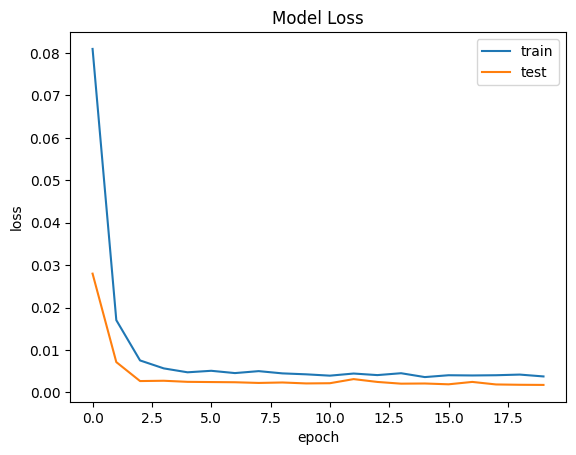

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

# Training loss metrics are very low, indicating the model is training well for the time-series.

16/16 [==============================] - 5s 48ms/step


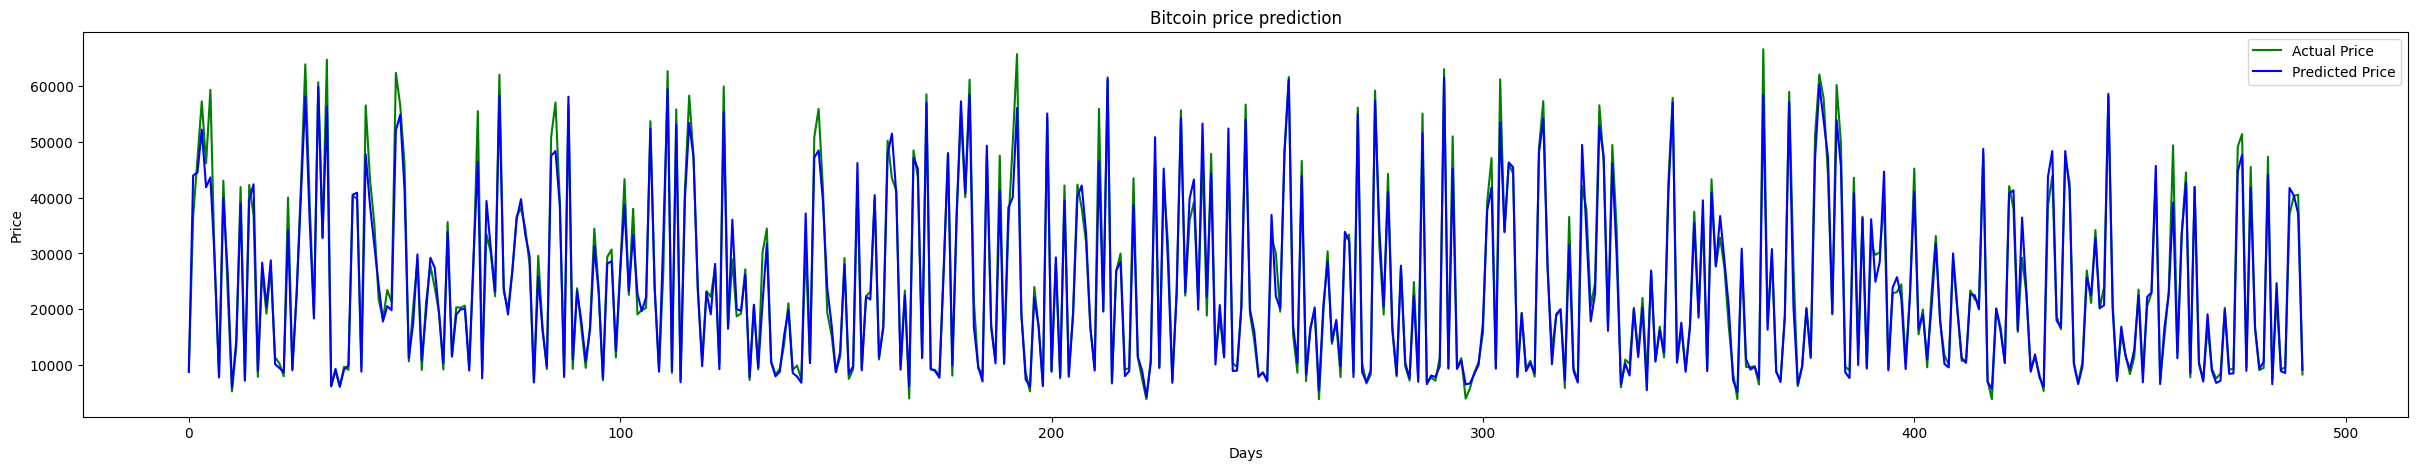

In [13]:
y_pred = model.predict(X_test)
y_test_inverse = sc.inverse_transform(y_test)
y_pred_inverse = sc.inverse_transform(y_pred)

plt.figure(figsize=(30,5))
plt.plot(y_test_inverse, label="Actual Price", color="green")
plt.plot(y_pred_inverse, label="Predicted Price", color="blue")

plt.title("Bitcoin price prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(loc="best")

plt.show()